# Meta-Automation

The ultimate objective of programming is to achieve automation, which generally requires a set of rigid algorithms defined by humans.

Thanks to the exponential growth of computing power, the rise of machine-learning forms practical meta-automation that do not require definitive algorithms but elegantly self-adapt using methods and models inspired by statistics and probability theory.

The increasing sophistication of the abstractions built on top of various machine-learning techniques gives us tools to displace manual chores with much more ease.

## Natural language processing

We will use a machine-learning assisted NLP (natural-language-processing) technique to build a text emotion-detection application, inspired by [this paper](https://www.aclweb.org/anthology/D18-1404.pdf) and [this training dataset](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp).

We will also use [fastText](https://fasttext.cc/), an NLP library open-sourced by Facebook Research, based on the [Word2vec](https://en.wikipedia.org/wiki/Word2vec) technique.

In [1]:
import pandas as pd

# load text with slightly hacky usage of the Pandas `read_csv()` function
df_train = pd.read_csv('emotions/train.txt', sep=';', names=['text', 'emotion'])
df_train

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [2]:
df_train['emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [3]:
# prefix emotion labels based on fastText's expected format
df_train['emotion'] = '__label__' + df_train['emotion'].str[:]
df_train['emotion'].value_counts()

__label__joy         5362
__label__sadness     4666
__label__anger       2159
__label__fear        1937
__label__love        1304
__label__surprise     572
Name: emotion, dtype: int64

In [4]:
from numpy import savetxt

# positively leverage "leaky abstraction" by using Numpy `savetxt()`
# output DataFrame as text file that each line would look like:
# __label__joy i feel strong and good overall
savetxt('emotions_train.txt', df_train[['emotion', 'text']].values, fmt='%s', delimiter=' ')

### Pre-process abstraction

In [5]:
def pre_process(fname: str, output: str):
    # load text
    df = pd.read_csv(fname, sep=';', names=['text', 'emotion'])
    # prefix emotions with __label__ for fastText standard
    df['emotion'] = '__label__' + df['emotion'].str[:]
    # output as fastText expected text file
    savetxt(output, df[['emotion', 'text']].values, fmt='%s', delimiter=' ')

In [6]:
pre_process('emotions/val.txt', 'emotions_val.txt')
pre_process('emotions/test.txt', 'emotions_test.txt')

In [49]:
import fasttext

model = fasttext.train_supervised(
    input='emotions_train.txt',
    autotuneValidationFile='emotions_val.txt',  # this would require extra time up to 5 min
    autotuneModelSize='1M',  # this also adds to the training time
)

In [50]:
model.test('emotions_test.txt')

(2000, 0.8835, 0.8835)

In [51]:
model.predict('lol')

(('__label__joy',), array([1.0000056]))

In [52]:
text = "Sorry honey, I tried to get flowers but now I'm just drunk in sitting in a pile of dandelion leafs. Happens to the best of us"
model.predict(text)

(('__label__joy',), array([0.27777389]))

In [53]:
model.predict(text.lower())

(('__label__sadness',), array([0.90288192]))

In [54]:
labels, scores = model.predict(text.lower())
print(labels[0].split('__label__')[-1], round(scores[0], 3))

sadness 0.903


In [55]:
# save the model
model.save_model('./emotions.bin')

### Post-process abstraction

In [56]:
def emotion_score(model, text):
    labels, scores = model.predict(text.lower())
    return {'emotion': labels[0].split('__label__')[-1], 'score': round(scores[0], 3)}

In [57]:
emotion_score(model, "Sorry honey, I tried to get flowers but now I'm just drunk in sitting in a pile of dandelion leafs. Happens to the best of us")

{'emotion': 'sadness', 'score': 0.903}

In [58]:
emotion_score(model, 'Sounds like a great cause...also have two teenagers so I appreciate the cause and underlying issues too.')

{'emotion': 'joy', 'score': 0.55}

In [59]:
emotion_score(model, "I have a mild fascination with city planning (ask me for good content sources if you're also into that), but stumbled on to two great vids on the TTC's subway evolution and GO's rail lines.")

{'emotion': 'joy', 'score': 0.999}

### Build a case

In [60]:
# download a youtube video's CC
import requests

# CC obtained from https://www.youtube.com/watch?v=CzSMC5rWvos
# inspect network activity and search for `timedtext`
# copy the URL from the GET request below
url = 'https://www.youtube.com/api/timedtext?v=CzSMC5rWvos&asr_langs=de,en,es,fr,it,ja,ko,nl,pt,ru&caps=asr&exp=xftt&xorp=true&xoaf=5&hl=en&ip=0.0.0.0&ipbits=0&expire=1615530631&sparams=ip,ipbits,expire,v,asr_langs,caps,exp,xorp,xoaf&signature=579F2EFAA169330AE6508E9E842DDE7F1E5767CD.C04A358157965E1049826EB448870761D8121579&key=yt8&lang=en&fmt=json3&xorb=2&xobt=3&xovt=3'
cc = requests.get(url)
cc = cc.json().get('events', [])
df_cc = pd.DataFrame(cc)
df_cc.head(10)

,tStartMs,dDurationMs,segs
0,190,5680,[{'utf8': 'I'm often asked -- and occasionally...
1,5870,5309,"[{'utf8': 'And it's like, you know, the only ""..."
2,11179,2271,[{'utf8': 'I don't associate with movements.'}]
3,13450,3180,"[{'utf8': 'I'm not an ""ism.""'}]"
4,16630,2950,[{'utf8': 'I just - I think for myself.'}]
5,19580,9000,[{'utf8': 'The moment when someone attaches to...
6,28580,4779,[{'utf8': 'and all the rest of the philosophy ...
7,33359,4101,[{'utf8': 'a conversation they will assert tha...
8,37460,3750,[{'utf8': 'to know about you because of that a...
9,41210,1789,[{'utf8': 'And that's not the way to have a co...


In [61]:
# a bit of cleanup
def parse_segs(segs):
    # assume a single segment subtitle
    # obtain only the first segment
    seg = segs[0]
    # assume all keys are `utf8` here
    text = seg.get('utf8', '')
    return ' '.join(text.lower().replace("'", '').split('\n'))

df_cc['text'] = df_cc['segs'].apply(parse_segs)
df = df_cc[['text']]
df.head(10)

,text
0,im often asked -- and occasionally in an accus...
1,"and its like, you know, the only ""ist"" i am is..."
2,i dont associate with movements.
3,"im not an ""ism."""
4,i just - i think for myself.
5,the moment when someone attaches to a philosop...
6,and all the rest of the philosophy that goes w...
7,a conversation they will assert that they alre...
8,to know about you because of that association.
9,and thats not the way to have a conversation.


In [62]:
# apply our emotion model
def add_emotion(row):
    em = emotion_score(model, row['text'])
    return pd.Series({**row, **em})

df = df.apply(add_emotion, axis=1)
df.head(10)

,text,emotion,score
0,im often asked -- and occasionally in an accus...,anger,0.572
1,"and its like, you know, the only ""ist"" i am is...",joy,0.372
2,i dont associate with movements.,joy,0.642
3,"im not an ""ism.""",joy,0.989
4,i just - i think for myself.,joy,0.874
5,the moment when someone attaches to a philosop...,anger,0.468
6,and all the rest of the philosophy that goes w...,anger,0.738
7,a conversation they will assert that they alre...,joy,0.998
8,to know about you because of that association.,joy,0.710
9,and thats not the way to have a conversation.,joy,0.542


In [63]:
df.value_counts('emotion')

emotion
joy         35
anger        9
sadness      7
fear         4
surprise     1
love         1
dtype: int64

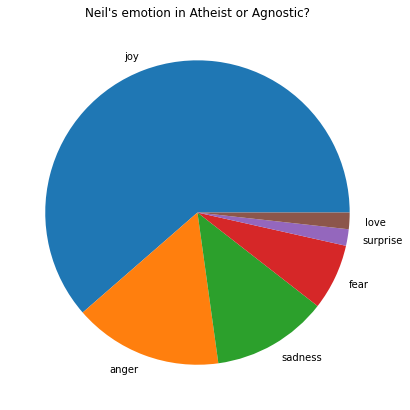

In [84]:
plot = df.value_counts('emotion').plot.pie(
    y='emotion',
    ylabel='',
    figsize=(7, 7),
    title="Neil's emotion in Atheist or Agnostic?",
)

In [64]:
df_80 = df.query('score > 0.8').reset_index(drop=True)
df_80.head(10)

,text,emotion,score
0,"im not an ""ism.""",joy,0.989
1,i just - i think for myself.,joy,0.874
2,a conversation they will assert that they alre...,joy,0.998
3,im sorry.,joy,0.853
4,"and assert, you know, whats going to happen in...",joy,0.967
5,"so what people are really after is, what is my...",joy,0.881
6,if its there but if its not wont be forced to ...,anger,0.827
7,supported.,joy,1.000
8,okay.,joy,1.000
9,i find this intriguing.,joy,0.966


In [65]:
df_80.value_counts('emotion')

emotion
joy         25
surprise     1
anger        1
dtype: int64

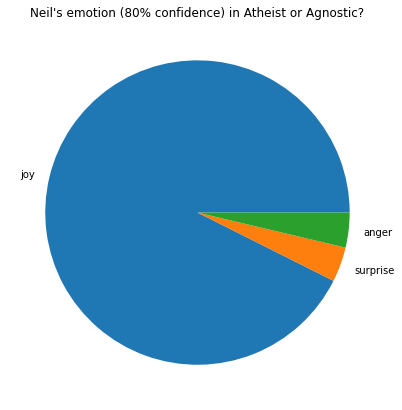

In [83]:
plot = df_80.value_counts('emotion').plot.pie(
    y='emotion',
    ylabel='',
    figsize=(7, 7),
    title="Neil's emotion (80% confidence) in Atheist or Agnostic?",
)

### Emotion-as-a-Service

The demonstrations below are accessible through a hosted version of [its source code](https://github.com/eqworks/emotion-api).

In [67]:
from flask import Flask, request, jsonify
import fasttext


app = Flask(__name__)
model = fasttext.load_model('./emotions.bin')


def emotion_score(model, text):
    labels, scores = model.predict(text.lower())
    return {'emotion': labels[0].split('__label__')[-1], 'score': round(scores[0], 3)}


@app.route('/')
def get_emotion():
    text = request.args.get('t', request.args.get('text', ''))

    if not text:
        return jsonify({'error': 'You need to supply a text'}), 400

    return jsonify({
        'text': text,
        **emotion_score(model, text),
    })

And access it as an API:

In [69]:
# import requests
emotion = requests.get('https://sneaky-smiling-printer.glitch.me', params={'t': 'Clap along if you know what happiness is to you'})
emotion.json()

{'emotion': 'joy',
 'score': 0.995,
 'text': 'Clap along if you know what happiness is to you'}